In [2]:
#import required modules
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#import csv file and overview the dataframe
crd = pd.read_csv("creditcard.csv")
crd.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#check the number of anomal points
crd['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

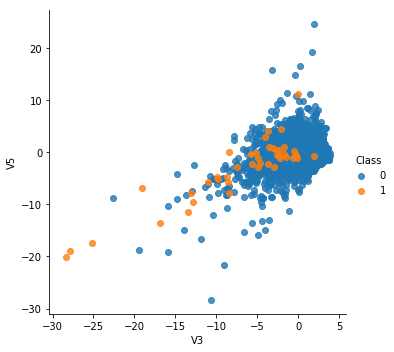

In [17]:
#check anomal points from the 2 feature distribution
#modify x and y to do feature engineering
sns.lmplot(x='V3', y='V5', hue='Class', 
           data=crd.sample(frac = 0.1), 
           fit_reg=False)

In [4]:
#divide postive/negative points
crd_pos = crd[crd['Class'] == 1]
crd_neg = crd[crd['Class'] == 0]

In [5]:
#construct Train, CV, Test set
crd_train, crd_test_neg = train_test_split(crd_neg, test_size=0.2, random_state=0)
crd_cv_pos, crd_test_pos = train_test_split(crd_pos, test_size=0.5, random_state=0)
crd_train_neg, crd_cv_neg = train_test_split(crd_train, test_size=0.25, random_state=0)

crd_cv = pd.concat([crd_cv_pos, crd_cv_neg])
crd_test = pd.concat([crd_test_pos, crd_test_neg])

In [8]:
#divide features and label of each data set
#Train set
crd_train_rm = crd_train.drop(['Class'], axis = 1)
crd_mean = crd_train_rm.describe().loc['mean'].values
cov = np.cov(crd_train_rm.values.T)

#CV set
crd_cv_cl = crd_cv['Class']
crd_cv_rm = crd_cv.drop(['Class'], axis = 1)

In [6]:
#define gaussian function
def gaussian(X, mu, cov):
    out = []
    det = np.linalg.det(cov)
    dev = (X - mu).values
    inv_cov = np.linalg.inv(cov)
    power = -(dev.dot(inv_cov)*dev).sum(axis = 1) / 2    
    out = np.exp(power) / (np.sqrt(2*np.pi) * (det**(1/2)))
    return out

In [158]:
#optimize epsilon
def findEpsilon(out, y, bin_):
    for i in range(len(out)):
        if np.sort(out)[i] != 0:
            epsilon = np.sort(out)[i]
            break
        else:
            continue
    
    test = epsilon
    score_arr = []
    precision = []
    recall = []
    f1 = []
    
    recall.append(0)
    precision.append(1)
    f1.append(0)     
    
    for i in range(bin_):     
        pred = (out < test).astype(int)

        tp = ((pred == y) & (pred == 1)).value_counts().loc[True]
        fp = ((pred != y) & (pred == 1)).value_counts().loc[True]
        fn = ((pred != y) & (pred == 0)).value_counts().loc[True]
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        f1.append(2*precision[i]*recall[i]/(precision[i] + recall[i]))
        test = test * 1000
        
    recall.append(1)
    precision.append(0)
    f1.append(0)   
    
    print("The best score on the Cross Validation set is %.2f" %f1[np.argmax(f1)])
    epsilon = epsilon * (1000 ** np.argmax(f1).astype(float) - 1)
    
    return epsilon, precision, recall

In [146]:
#draw precision-recall curve in custom mode
def drawPRcurve(recall, precision):
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    return

In [159]:
#generate gaussian output and tune epsilon
out = gaussian(crd_cv_rm, crd_mean, cov)
epsilon, precision, recall = findEpsilon(out, crd_cv_cl, 100)

The best score on the Cross Validation set is 0.64


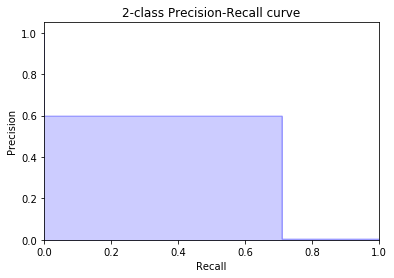

In [161]:
#draw precision-recall curve using existing library
precision_sh, recall_sh, thresholds = precision_recall_curve(crd_test_cl, pred)
drawPRcurve(recall_sh, precision_sh)

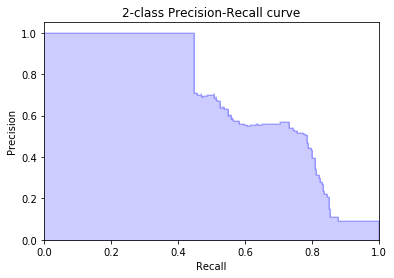

In [160]:
drawPRcurve(recall, precision)

In [129]:
#based on gaussian parameters and epsilon, evaluate the model using Test set.
crd_test_cl = crd_test['Class']
crd_test_rm = crd_test.drop(['Class'], axis = 1)

test_out = gaussian(crd_test_rm, crd_mean, cov)

pred = (test_out < epsilon).astype(int)

tp = ((pred == crd_test_cl) & (pred == 1)).value_counts().loc[True]
fp = ((pred != crd_test_cl) & (pred == 1)).value_counts().loc[True]
fn = ((pred != crd_test_cl) & (pred == 0)).value_counts().loc[True]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2*precision*recall/(precision + recall)
print(f1)



0.6493506493506495
